<a href="https://colab.research.google.com/github/nmach22/Claude-Monet-painting-generator/blob/main/model_experiment_CycleGAN_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Data

## Install Required Libraries

In [1]:
! pip install kaggle==1.5.16 --upgrade -q
! pip install wandb --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Download kaggle files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c gan-getting-started

 99% 365M/367M [00:07<00:00, 55.4MB/s]
100% 367M/367M [00:07<00:00, 48.1MB/s]


## Unzip Data

In [7]:
! unzip -q /content/gan-getting-started.zip

## login Wandb

In [12]:
import wandb

wandb.login()

wandb.init(
    project="Generate Monet paintings",
    entity="nmach22-free-university-of-tbilisi-"
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: nmach22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Imports

In [13]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

### Seed

In [14]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
set_seed(45)

## Dataset And DataLoader

In [17]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()
            ])
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return photo_img, monet_img

    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [18]:
img_ds = ImageDataset('./monet_jpg/', './photo_jpg/')

In [19]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [20]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)

    return img

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


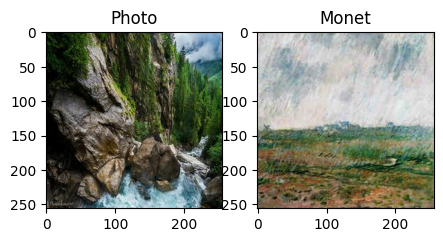

In [21]:
photo_img, monet_img = next(iter(img_dl))

f = plt.figure(figsize=(5, 5))

f.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))

## Load and Save chackpoints

In [22]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

def save_checkpoint(state, save_path):
    torch.save(state, save_path)

## Model

### Upsample and DownSample

In [23]:
def Downsample(in_ch:int, out_ch:int, use_norm=True) -> nn.Sequential:
    """
    Downsample block for U-Net encoder (contracting path)
    - Conv2d with stride=2 to reduce spatial dimensions by half
    - InstanceNorm2d for normalization (optional, typically skipped in first layer)
    - LeakyReLU activation
    """
    layers = [
        nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False)
    ]

    if use_norm:
        layers.append(nn.InstanceNorm2d(out_ch))

    layers.append(nn.LeakyReLU(0.2, inplace=True))

    return nn.Sequential(*layers)


In [24]:
def Upsample(in_ch:int, out_ch:int, use_dropout=True, dropout_ratio=0.5) -> nn.Sequential:
    """
    Upsample block for U-Net decoder (expanding path)
    - ConvTranspose2d with stride=2 to increase spatial dimensions by 2x
    - InstanceNorm2d for normalization
    - Dropout for regularization (optional)
    - ReLU activation
    """
    layers = [
        nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(out_ch)
    ]

    if use_dropout:
        layers.append(nn.Dropout(dropout_ratio))

    layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)


### U-Net Generator

In [37]:
class Generator(nn.Module):
    """
    U-Net Generator for CycleGAN
    Architecture: Encoder-Decoder with skip connections
    Input: 3-channel image (RGB)
    Output: 3-channel image (RGB)
    """
    def __init__(self, in_ch=3, out_ch=3, base_ch=64):
        super(Generator, self).__init__()

        # Encoder (Contracting Path)
        self.down1 = Downsample(in_ch, base_ch, use_norm=False)      # 128x128
        self.down2 = Downsample(base_ch, base_ch*2)                  # 64x64
        self.down3 = Downsample(base_ch*2, base_ch*4)                # 32x32
        self.down4 = Downsample(base_ch*4, base_ch*8)                # 16x16
        self.down5 = Downsample(base_ch*8, base_ch*8)                # 8x8
        self.down6 = Downsample(base_ch*8, base_ch*8)                # 4x4
        self.down7 = Downsample(base_ch*8, base_ch*8)                # 2x2

        # Bottleneck
        self.bottleneck = Downsample(base_ch*8, base_ch*8, use_norm=False)  # 1x1

        # Decoder (Expanding Path)
        self.up1 = Upsample(base_ch*8, base_ch*8, use_dropout=True)         # 2x2
        self.up2 = Upsample(base_ch*16, base_ch*8, use_dropout=True)        # 4x4
        self.up3 = Upsample(base_ch*16, base_ch*8, use_dropout=True)        # 8x8
        self.up4 = Upsample(base_ch*16, base_ch*8, use_dropout=False)       # 16x16
        self.up5 = Upsample(base_ch*16, base_ch*4, use_dropout=False)       # 32x32
        self.up6 = Upsample(base_ch*8, base_ch*2, use_dropout=False)        # 64x64
        self.up7 = Upsample(base_ch*4, base_ch, use_dropout=False)          # 128x128

        # Final output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(base_ch*2, out_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        # Encoder with skip connections
        d1 = self.down1(x)      # 128x128
        d2 = self.down2(d1)     # 64x64
        d3 = self.down3(d2)     # 32x32
        d4 = self.down4(d3)     # 16x16
        d5 = self.down5(d4)     # 8x8
        d6 = self.down6(d5)     # 4x4
        d7 = self.down7(d6)     # 2x2

        # Bottleneck
        bottleneck = self.bottleneck(d7)  # 1x1

        # Decoder with skip connections (concatenate)
        u1 = self.up1(bottleneck)                    # 2x2
        u1 = torch.cat([u1, d7], dim=1)              # Skip connection

        u2 = self.up2(u1)                            # 4x4
        u2 = torch.cat([u2, d6], dim=1)              # Skip connection

        u3 = self.up3(u2)                            # 8x8
        u3 = torch.cat([u3, d5], dim=1)              # Skip connection

        u4 = self.up4(u3)                            # 16x16
        u4 = torch.cat([u4, d4], dim=1)              # Skip connection

        u5 = self.up5(u4)                            # 32x32
        u5 = torch.cat([u5, d3], dim=1)              # Skip connection

        u6 = self.up6(u5)                            # 64x64
        u6 = torch.cat([u6, d2], dim=1)              # Skip connection

        u7 = self.up7(u6)                            # 128x128
        u7 = torch.cat([u7, d1], dim=1)              # Skip connection

        # Final output
        output = self.final(u7)                      # 256x256

        return output


#### Test Generator

In [38]:
# Initialize generator
generator = Generator(in_ch=3, out_ch=3, base_ch=64).to(device)

# Print model architecture
print(generator)
print("\n" + "="*80)
print(f"Total parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in generator.parameters() if p.requires_grad):,}")

Generator(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down5): Sequential(
    (0): 

In [39]:
# Test with random input
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = generator(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Output range: [-1.000, 1.000]


### Discriminator (PatchGAN)

In [40]:
class Discriminator(nn.Module):
    """
    PatchGAN Discriminator for CycleGAN
    - Classifies whether overlapping image patches are real or fake
    - Outputs a matrix of predictions rather than a single value
    - Uses 70x70 receptive field (commonly used in CycleGAN)
    """
    def __init__(self, in_ch=3, base_ch=64):
        super(Discriminator, self).__init__()

        # C64: No normalization in first layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # C128: With normalization
        self.layer2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(base_ch*2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # C256: With normalization
        self.layer3 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(base_ch*4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # C512: With normalization, stride=1
        self.layer4 = nn.Sequential(
            nn.Conv2d(base_ch*4, base_ch*8, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(base_ch*8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Final output layer: Single channel output (patch predictions)
        self.layer5 = nn.Sequential(
            nn.Conv2d(base_ch*8, 1, kernel_size=4, stride=1, padding=1)
            # No sigmoid here - will use MSE loss or BCE with logits
        )

    def forward(self, x):
        x = self.layer1(x)    # 128x128
        x = self.layer2(x)    # 64x64
        x = self.layer3(x)    # 32x32
        x = self.layer4(x)    # 31x31
        x = self.layer5(x)    # 30x30
        return x


#### Test Discriminator

In [41]:
# Initialize discriminator
discriminator = Discriminator(in_ch=3, base_ch=64).to(device)

# Print model architecture
print(discriminator)
print("\n" + "="*80)
print(f"Total parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in discriminator.parameters() if p.requires_grad):,}")

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer5): Sequential(
    (0): Con

In [42]:
# Test with random input
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = discriminator(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output is a matrix of patch predictions (PatchGAN)")
print(f"Each value represents real/fake prediction for a receptive field")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 30, 30])
Output is a matrix of patch predictions (PatchGAN)
Each value represents real/fake prediction for a receptive field


In [43]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

## Additional Functions

In [44]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad


In [45]:
# https://arxiv.org/pdf/1612.07828.pdf
# Save 50 generated fake imgs and sample through them
# to feed discriminators to avoid large oscillations
# from iterations to iterations.
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [46]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs) / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [47]:
class AvgStats(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.losses = []
        self.its = []

    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

## Define GAN Class

In [48]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        self.start_epoch = 0

    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)

    def load_weights(self, ckpt_path):
        ckpt = load_checkpoint(ckpt_path)
        self.start_epoch = ckpt['epoch']
        self.gen_mtp.load_state_dict(ckpt['gen_mtp'])
        self.gen_ptm.load_state_dict(ckpt['gen_ptm'])
        self.desc_m.load_state_dict(ckpt['desc_m'])
        self.desc_p.load_state_dict(ckpt['desc_p'])
        self.adam_gen.load_state_dict(ckpt['optimizer_gen'])
        self.adam_desc.load_state_dict(ckpt['optimizer_desc'])

    def train(self, photo_dl):
        for epoch in range(self.start_epoch, self.start_epoch + self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo

                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()

                wandb.log({
                    "Generator Loss": total_gen_loss.item(),
                    "Discriminator Loss": total_desc_loss.item(),
                    "Epoch": epoch
                })

                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': self.gen_mtp.state_dict(),
                'gen_ptm': self.gen_ptm.state_dict(),
                'desc_m': self.desc_m.state_dict(),
                'desc_p': self.desc_p.state_dict(),
                'optimizer_gen': self.adam_gen.state_dict(),
                'optimizer_desc': self.adam_desc.state_dict()
            }
            # save_checkpoint(save_dict, 'current.ckpt')
            save_checkpoint(save_dict, f'./drive/MyDrive/checkpoints/U-Net/checkpoint_{epoch+1}.ckpt')

            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time

            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)

            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" %
                                                (epoch+1, avg_gen_loss, avg_desc_loss))

            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [49]:
gan = CycleGAN(3, 3, 10, device)

In [50]:
# Save before train
def save_parameters():
    return {
        'epoch': 0,
        'gen_mtp': gan.gen_mtp.state_dict(),
        'gen_ptm': gan.gen_ptm.state_dict(),
        'desc_m': gan.desc_m.state_dict(),
        'desc_p': gan.desc_p.state_dict(),
        'optimizer_gen': gan.adam_gen.state_dict(),
        'optimizer_desc': gan.adam_desc.state_dict()
    }

In [ ]:
import glob
import os

checkpoint_dir = './drive/MyDrive/checkpoints/U-Net'
os.makedirs(checkpoint_dir, exist_ok=True)

# Find all checkpoints
checkpoints = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))

if checkpoints:
    # Select the latest checkpoint based on modification time
    latest_ckpt = max(checkpoints, key=os.path.getctime)
    print(f"Found checkpoint: {latest_ckpt}")
    gan.load_weights(latest_ckpt)
    print(f"Resuming from epoch {gan.start_epoch}")
else:
    # !mkdir -p ./drive/MyDrive/checkpoints/U-Net
    save_dict = save_parameters()
    save_checkpoint(save_dict, './drive/MyDrive/checkpoints/U-Net/init.ckpt')
    print("No checkpoint found, starting from epoch 0")

gan.train(img_dl)

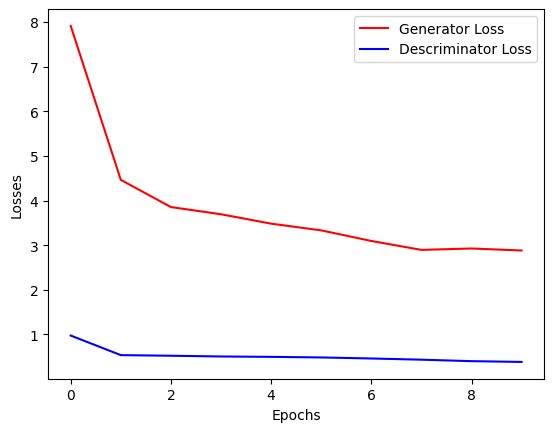

In [52]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

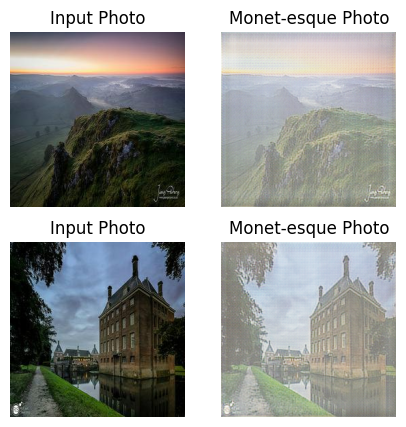

In [55]:
photo_img0, _ = next(iter(img_dl))
photo_img0 = unnorm(photo_img0)

photo_img1, _ = next(iter(img_dl))
photo_img1 = unnorm(photo_img1)
def plot_input_output():
    _, ax = plt.subplots(2, 2, figsize=(5, 5))
    for i in range(2):
        photo_img = photo_img0 if i == 0 else photo_img1
        pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
        pred_monet = unnorm(pred_monet)

        ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
        ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque Photo")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

plot_input_output()

In [56]:
ckpts = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))
for ckpt in ckpts:
    print(f"checkpoint path: {ckpt}")

checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_8.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_9.ckpt
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_10.ckpt


 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_8.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_8.ckpt


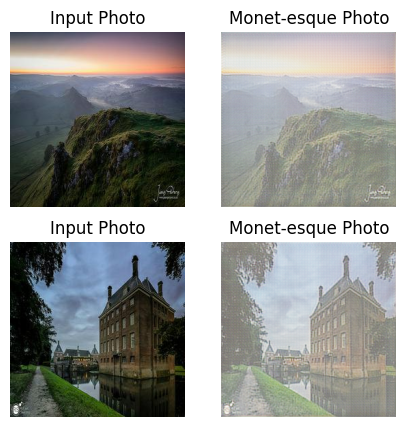

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_9.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_9.ckpt


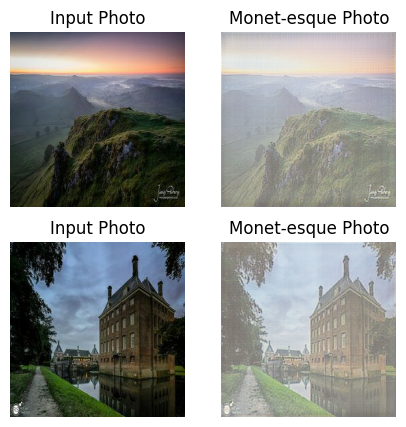

 [*] Loading checkpoint from ./drive/MyDrive/checkpoints/U-Net/checkpoint_10.ckpt succeed!
checkpoint path: ./drive/MyDrive/checkpoints/U-Net/checkpoint_10.ckpt


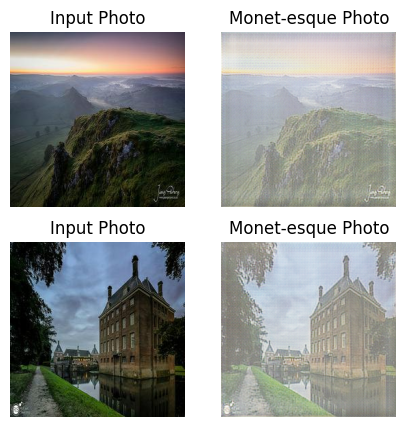

In [57]:
for ckpt in ckpts:
    gan.load_weights(ckpt)
    print(f"checkpoint path: {ckpt}")
    plot_input_output()